<a href="https://colab.research.google.com/github/lars-x/Umu_Labs/blob/main/Lab3/Lab3_Highway_DQN_rlagents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary

The project consists of three repositories in GitHub.

## The main Colab Notebook is in:
```
git@github.com:lars-x/Umu_Labs.git
```
This Colab Notebook, The Lab 3 Notebook, is here:

https://github.com/lars-x/Umu_Labs/blob/main/Lab3/Lab3_Highway_DQN_rlagents.ipynb

Obs 1! Click the button "Open in Colab" to see the reesults and videos from the last execution i Colab.

Obs 2! A backup to a copy of this Notebook in Colab:

https://colab.research.google.com/drive/1lkkKW_Y-jn4SLHQUgEcIg30QagXjn-n7?usp=sharing 

## Two forked repositories

When the Notebook Lab3_Highway_DQN_rlagents.ipynb is executed in Colab two "helper repositories" (forked to github.com/lars-x) are downladed from GitHub to Colab:
```
!pip install git+https://github.com/lars-x/highway-env

!pip install git+https://github.com/lars-x/rl-agents
```
## lane_change_reward
The file:

https://github.com/lars-x/highway-env/blob/master/highway_env/envs/highway_env.py

is the most interesting.

I changed the **_reward** function by adding **lane_change_reward** like:
```
    def _reward(self, action: Action) -> float:
        neighbours = self.road.network.all_side_lanes(self.vehicle.lane_index)
        lane = self.vehicle.target_lane_index[2] if isinstance(self.vehicle, ControlledVehicle) \
            else self.vehicle.lane_index[2]
        scaled_speed = utils.lmap(self.vehicle.speed, self.config["reward_speed_range"], [0, 1])
        lane_change = action == 0 or action == 2
        reward = \
            + self.config["collision_reward"] * self.vehicle.crashed \
            + self.config["right_lane_reward"] * lane / max(len(neighbours) - 1, 1) \
            + self.config["high_speed_reward"] * np.clip(scaled_speed, 0, 1) \
            + self.config["lane_change_reward"] * lane_change
        # reward = utils.lmap(Value, [Max negative value, Max positive value], [0, 1])
        reward = utils.lmap(reward,
                          [self.config["collision_reward"] + self.config["lane_change_reward"],
                           self.config["high_speed_reward"] + self.config["right_lane_reward"]],
                          [0, 1])
        reward = 0 if not self.vehicle.on_road else reward
        return reward
```

## Training
I wanted to have two visually interesting scenarios.

* As simple as possible, but not to simple
* At least 3 lanes
* At least 5 vehicles
* For the scenario with lane_change_reward < 0. "A little" lane change
* As short training time as possible
* And a lot of crashes...

Some "explorative training" resulted in the following baseline parameters:
```
env.config["lane_change_reward"] = -1
env.config["vehicles_count"] = 10
env.config["lanes_count"] = 3

num_episodes = 100
```

Lab3 is based on highway-env https://github.com/eleurent/highway-env. In 
envs/highway_env.py, the vehicle is rewarded for reaching a high speed, staying on the rightmost lanes and avoiding collisions for in highway driving (highway-env). Your task is to add an additional term to penalize changing lanes. (Ideally we should penalize changing lanes to the left more than changing to the right, but this is a simplified exercise.) Please refer to envs/roundabout_env for reference.

Steps:

1) Fork the highway-env repository to your own GitHub account, and modify highway_env.py. (if you are not familiar with GitHub, I recommend installing GitHub Desktop https://desktop.github.com.)

2) Replace 
!pip install highway-env 
with path to your own repository:
!pip install git+https://github.com/USERNAME/highway-env

3) Train your agent for different values of lane_change_reward, and different environments with varying complexity, starting from the simplest:

env.config["lane_change_reward"] = 0

env.config["vehicles_count"] = 0

env.config["lanes_count"] = 2

env.config["initial_lane_id"] = 0

In this simple environment, during testing the vehicle should switch to the right lane quickly and stay in the right lane. (It is possible for it to stay in the left lane during testing if your training num_episodes is too small, since the agent may not have had a chance to try the lane change action during training.)
Try different values of lane_change_reward (e.g., -0.1, -1, -10, etc. note that it must be negative), and different numbers of vehicles/lanes. Make lane_change_reward very negative until you observe that the vehicle prefers *collision* to *lane change to avoid collision*. Submit your IPython Notebook, and a short report (or text blocks within the Notebook) describing the different configurations you have tried, and your observations for each config, including two configs that differ only in the lane_change_reward, one with no or rare collisions, one with frequent collisions.

Notes: 

1) More complex environments demand more training time (more num_episodes), so do not make your environment more complex than necessary. You may try increasing the  vehicles_density and reward_speed_range to increase the chances of collision. You may also find "Script to Stop Google Colab From Disconnecting" to be helpful.

2) You may want to tune DQN hyperparams in configs/HighwayEnv/agents/DQNAgent/dqn.json, e.g., discount factor gamma, and epsilon greedy exploration params tau, temperature, final_temperature for different num_episodes.

3) The error message "fatal: destination path 'highway-env' already exists and is not an empty directory" in the first code cell can be safely ignored.


# Training a DQN on `highway-v0` with rlagents
## Import requirements

In [ ]:
# !rm -rf highway-env
# !ls -la

In [ ]:
# Environment
#!pip install highway-env
!pip install git+https://github.com/lars-x/highway-env
import gym
import highway_env

# Agent
!pip install git+https://github.com/lars-x/rl-agents

# Visualisation utils
import sys
%load_ext tensorboard
!pip install tensorboardx gym pyvirtualdisplay
!apt-get install -y xvfb python-opengl ffmpeg
!git clone https://github.com/lars-x/highway-env.git
sys.path.insert(0, '/content/highway-env/scripts/')
from utils import show_videos

# Videos for env.config["lane_change_reward"] = 0

## Training

Prepare environment, agent, and evaluation process.


In [ ]:
from rl_agents.trainer.evaluation import Evaluation
from rl_agents.agents.common.factory import load_agent, load_environment

# Get the environment and agent configurations from the rl-agents repository
!git clone https://github.com/lars-x/rl-agents.git
%cd /content/rl-agents/scripts/
env_config = 'configs/HighwayEnv/env.json'
agent_config = 'configs/HighwayEnv/agents/DQNAgent/dqn.json'

{'action': {'type': 'DiscreteMetaAction'},
 'centering_position': [0.3, 0.5],
 'collision_reward': -1,
 'controlled_vehicles': 1,
 'duration': 40,
 'ego_spacing': 2,
 'high_speed_reward': 0.4,
 'id': 'highway-v0',
 'import_module': 'highway_env',
 'initial_lane_id': 0,
 'lane_change_reward': 0,
 'lanes_count': 3,
 'manual_control': False,
 'observation': {'type': 'Kinematics'},
 'offroad_terminal': False,
 'offscreen_rendering': False,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'policy_frequency': 1,
 'real_time_rendering': False,
 'render_agent': True,
 'reward_speed_range': [20, 30],
 'right_lane_reward': 0.1,
 'scaling': 5.5,
 'screen_height': 150,
 'screen_width': 600,
 'show_trajectories': False,
 'simulation_frequency': 15,
 'vehicles_count': 10,
 'vehicles_density': 1}
'configs/HighwayEnv/agents/DQNAgent/dqn.json'


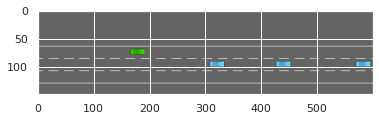

Ready to train <rl_agents.agents.deep_q_network.pytorch.DQNAgent object at 0x7fd90df5eb50> on <HighwayEnv<highway-v0>>


In [ ]:
env = load_environment(env_config)
import pprint
from matplotlib import pyplot as plt
env.config["lane_change_reward"] = 0
env.config["vehicles_count"] = 10
# env.config['reward_speed_range'] = [0, 100]
env.config["lanes_count"] = 3
env.config["initial_lane_id"] = 0
pprint.pprint(env.config)
pprint.pprint(agent_config)

env.reset()
plt.imshow(env.render(mode="rgb_array"))
plt.show()

agent = load_agent(agent_config, env)
evaluation = Evaluation(env, agent, num_episodes=100, display_env=False)
print(f"Ready to train {agent} on {env}")

Start training. Run tensorboard locally to visualize training.

In [ ]:
# %tensorboard --logdir "{evaluation.directory}"
evaluation.train()

[INFO] Episode 0 score: 12.9 
[INFO] Episode 1 score: 1.9 
[INFO] Episode 2 score: 2.3 
[INFO] Episode 3 score: 7.6 
[INFO] Episode 4 score: 2.0 
[INFO] Episode 5 score: 4.5 
[INFO] Episode 6 score: 10.2 
[INFO] Episode 7 score: 8.9 
[INFO] Episode 8 score: 3.1 
[INFO] Episode 9 score: 8.4 
[INFO] Episode 10 score: 30.2 
[INFO] Episode 11 score: 4.5 
[INFO] Episode 12 score: 20.3 
[INFO] Episode 13 score: 10.4 
[INFO] Episode 14 score: 15.0 
[INFO] Episode 15 score: 5.1 
[INFO] Episode 16 score: 7.5 
[INFO] Episode 17 score: 4.0 
[INFO] Episode 18 score: 1.9 
[INFO] Episode 19 score: 12.3 
[INFO] Episode 20 score: 7.7 
[INFO] Episode 21 score: 15.4 
[INFO] Episode 22 score: 9.0 
[INFO] Episode 23 score: 31.1 
[INFO] Episode 24 score: 10.2 
[INFO] Episode 25 score: 7.2 
[INFO] Episode 26 score: 14.4 
[INFO] Episode 27 score: 6.7 
[INFO] Episode 28 score: 13.5 
[INFO] Episode 29 score: 15.2 
[INFO] Episode 30 score: 1.8 
[INFO] Episode 31 score: 2.5 
[INFO] Episode 32 score: 5.7 
[INFO] 

INFO: Finished writing results. You can upload them to the scoreboard via gym.upload('/content/rl-agents/scripts/out/HighwayEnv/DQNAgent/run_20210531-011612_58')


Progress can be visualised in the tensorboard cell above, which should update every 30s (or manually). You may need to click the *Fit domain to data* buttons below each graph.

## Testing

Run the learned policy for a few episodes.

In [ ]:
#env = load_environment(env_config)
env.configure({"offscreen_rendering": True})
agent = load_agent(agent_config, env)
evaluation = Evaluation(env, agent, num_episodes=3, recover=True)
evaluation.test()
show_videos(evaluation.run_directory)

[INFO] Choosing GPU device: 0, memory used: 1056 
[INFO] Loaded DQNAgent model from out/HighwayEnv/DQNAgent/saved_models/latest.tar 


INFO: Creating monitor directory out/HighwayEnv/DQNAgent/run_20210531-011814_58
INFO: Starting new video recorder writing to /content/rl-agents/scripts/out/HighwayEnv/DQNAgent/run_20210531-011814_58/openaigym.video.1.58.video000000.mp4


[INFO] Episode 0 score: 8.8 


INFO: Starting new video recorder writing to /content/rl-agents/scripts/out/HighwayEnv/DQNAgent/run_20210531-011814_58/openaigym.video.1.58.video000001.mp4


[INFO] Episode 1 score: 12.1 


INFO: Starting new video recorder writing to /content/rl-agents/scripts/out/HighwayEnv/DQNAgent/run_20210531-011814_58/openaigym.video.1.58.video000002.mp4


[INFO] Episode 2 score: 8.0 


INFO: Finished writing results. You can upload them to the scoreboard via gym.upload('/content/rl-agents/scripts/out/HighwayEnv/DQNAgent/run_20210531-011814_58')


# Videos for env.config["lane_change_reward"] = -1

INFO: Making new env: highway-v0
{'action': {'type': 'DiscreteMetaAction'},
 'centering_position': [0.3, 0.5],
 'collision_reward': -1,
 'controlled_vehicles': 1,
 'duration': 40,
 'ego_spacing': 2,
 'high_speed_reward': 0.4,
 'id': 'highway-v0',
 'import_module': 'highway_env',
 'initial_lane_id': 0,
 'lane_change_reward': -1,
 'lanes_count': 3,
 'manual_control': False,
 'observation': {'type': 'Kinematics'},
 'offroad_terminal': False,
 'offscreen_rendering': False,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'policy_frequency': 1,
 'real_time_rendering': False,
 'render_agent': True,
 'reward_speed_range': [20, 30],
 'right_lane_reward': 0.1,
 'scaling': 5.5,
 'screen_height': 150,
 'screen_width': 600,
 'show_trajectories': False,
 'simulation_frequency': 15,
 'vehicles_count': 10,
 'vehicles_density': 1}
'configs/HighwayEnv/agents/DQNAgent/dqn.json'


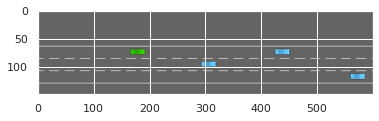

[INFO] Choosing GPU device: 0, memory used: 1058 


INFO: Creating monitor directory out/HighwayEnv/DQNAgent/run_20210531-011826_58
Ready to train <rl_agents.agents.deep_q_network.pytorch.DQNAgent object at 0x7fd8feb9c190> on <HighwayEnv<highway-v0>>


In [ ]:
env = load_environment(env_config)
import pprint
from matplotlib import pyplot as plt
env.config["lane_change_reward"] = -1
env.config["vehicles_count"] = 10
# env.config['reward_speed_range'] = [0, 100]
env.config["lanes_count"] = 3
env.config["initial_lane_id"] = 0
pprint.pprint(env.config)
pprint.pprint(agent_config)

env.reset()
plt.imshow(env.render(mode="rgb_array"))
plt.show()

agent = load_agent(agent_config, env)
evaluation = Evaluation(env, agent, num_episodes=100, display_env=False)
print(f"Ready to train {agent} on {env}")

In [ ]:
# %tensorboard --logdir "{evaluation.directory}"
evaluation.train()

[INFO] Episode 0 score: 16.0 
[INFO] Episode 1 score: 3.7 
[INFO] Episode 2 score: 3.9 
[INFO] Episode 3 score: 14.6 
[INFO] Episode 4 score: 1.0 
[INFO] Episode 5 score: 23.4 
[INFO] Episode 6 score: 2.8 
[INFO] Episode 7 score: 9.1 
[INFO] Episode 8 score: 30.7 
[INFO] Episode 9 score: 7.7 
[INFO] Episode 10 score: 14.5 
[INFO] Episode 11 score: 7.7 
[INFO] Episode 12 score: 4.9 
[INFO] Episode 13 score: 6.3 
[INFO] Episode 14 score: 19.5 
[INFO] Episode 15 score: 1.8 
[INFO] Episode 16 score: 6.0 
[INFO] Episode 17 score: 19.4 
[INFO] Episode 18 score: 13.4 
[INFO] Episode 19 score: 2.1 
[INFO] Episode 20 score: 2.3 
[INFO] Episode 21 score: 10.3 
[INFO] Episode 22 score: 7.3 
[INFO] Episode 23 score: 28.9 
[INFO] Episode 24 score: 1.4 
[INFO] Episode 25 score: 2.7 
[INFO] Episode 26 score: 25.6 
[INFO] Episode 27 score: 14.4 
[INFO] Episode 28 score: 9.3 
[INFO] Episode 29 score: 3.0 
[INFO] Episode 30 score: 2.0 
[INFO] Episode 31 score: 4.3 
[INFO] Episode 32 score: 16.5 
[INFO] 

INFO: Finished writing results. You can upload them to the scoreboard via gym.upload('/content/rl-agents/scripts/out/HighwayEnv/DQNAgent/run_20210531-011826_58')


In [ ]:
env.configure({"offscreen_rendering": True})
agent = load_agent(agent_config, env)
evaluation = Evaluation(env, agent, num_episodes=3, recover=True)
evaluation.test()
show_videos(evaluation.run_directory)

[INFO] Choosing GPU device: 0, memory used: 1060 
[INFO] Loaded DQNAgent model from out/HighwayEnv/DQNAgent/saved_models/latest.tar 


INFO: Creating monitor directory out/HighwayEnv/DQNAgent/run_20210531-012021_58
INFO: Starting new video recorder writing to /content/rl-agents/scripts/out/HighwayEnv/DQNAgent/run_20210531-012021_58/openaigym.video.3.58.video000000.mp4


[INFO] Episode 0 score: 32.2 


INFO: Starting new video recorder writing to /content/rl-agents/scripts/out/HighwayEnv/DQNAgent/run_20210531-012021_58/openaigym.video.3.58.video000001.mp4


[INFO] Episode 1 score: 17.1 


INFO: Starting new video recorder writing to /content/rl-agents/scripts/out/HighwayEnv/DQNAgent/run_20210531-012021_58/openaigym.video.3.58.video000002.mp4


[INFO] Episode 2 score: 32.3 


INFO: Finished writing results. You can upload them to the scoreboard via gym.upload('/content/rl-agents/scripts/out/HighwayEnv/DQNAgent/run_20210531-012021_58')
